<a href="https://colab.research.google.com/github/Sundaravelss/Creativity-Assessment-Scoring-using-NLP/blob/main/Creativity_assessment_scoring_by_Fine_tuning_Bert_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#checking for gpu instance

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
#setting device to use gpu

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

In [ ]:
#loading the dataset
import pandas as pd

df=pd.read_excel('./final_data_english.xlsx')
df

,Unnamed: 0,sentence,label
0,0,Collect water,3.0
1,1,parachute,4.0
2,2,Sun protection.,2.0
3,3,against rain,1.0
4,4,protection from the rain,1.0
...,...,...,...
1134,1134,hat holder,4.0
1135,1135,Kite,9.0
1136,1136,Wall decoration,4.0
1137,1137,pole,4.0


In [ ]:
#counting number of unique labels(scores here)
print('no. of unique values:',len(df.label.unique()))
df.label.value_counts()

no. of unique values: 17


4.0    178
3.0    173
3.5    113
5.0    100
2.5     92
4.5     87
2.0     70
6.0     68
1.5     60
1.0     60
5.5     45
6.5     34
7.0     32
8.0     14
7.5     10
8.5      2
9.0      1
Name: label, dtype: int64

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

In [ ]:
labels

array([3., 4., 2., ..., 4., 4., 4.])

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
#View tokenized sentence
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Collect water
Tokenized:  ['collect', 'water']
Token IDs:  [8145, 2300]


In [ ]:
#getting maximum length of the sentence in the dataset
length=[]
max_len = 0
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    #print(len(input_ids))
    #adding length to the list to plot it
    length.append(len(input_ids))
    max_len = max(max_len,len(input_ids))

print('Max sentence tokens: ', max_len)

Max sentence tokens:  50


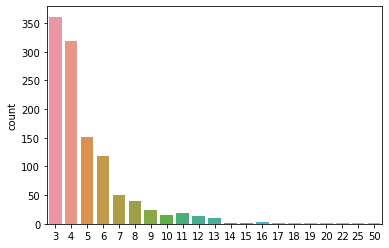

In [ ]:
import seaborn as sns

sns.countplot(length)

#sns.distplot(length)

In [ ]:
#maximum number of words in a sentence
df.sentence.map(len).max()

236

In [ ]:
for sent in sentences:
  if(len(sent)==236):
    print('The sentence which has the maximum number of words is:',sent, len(sent))

The sentence which has the maximum number of words is: small rain recovery by reversing the umbrella and adding a pipe use (possibility to stack in cascade to increase the capacity). A sports equipment to work flexibility (use the handle for example catch the foot and allow to pull the leg) 236


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent, add_special_tokens = True, max_length = 15,pad_to_max_length = True,return_attention_mask = True, return_tensors = 'pt',truncation=True )    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Collect water
Token IDs: tensor([ 101, 8145, 2300,  102,    0,    0,    0,    0,    0,    0])


In [ ]:
#changing labels to tensor and dtype as float for regression and long for classification
labels = torch.tensor(labels,dtype=torch.float)
labels[0]

tensor(3.)

In [ ]:
#attention mask (simply differentiates padding from non-padding).
attention_masks[0]

tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,025 training samples
  114 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#hyperparameter 16 or 32
batch_size = 16
#dataloader
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 1, # The number of output labels--10 (1 to 9) or --17 (if 0.5 is to be included.e.g,1,1.5,2..) for classification
                    #num_labels=1 for regression task   
    output_attentions = False,
    output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
#optimizing with adamw
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8  )


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels for classification
'''def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)'''

# Function to calculate the accuracy of our predictions vs labels for regression
def flat_accuracy(preds,labels):
  labels_flat=labels.flatten()  #flattening the labels
  labels_flat=np.round(labels_flat)  #rounding to 0 decimal points
  preds_flat=preds.flatten()     #flattening the predictions
  preds_flat=np.round(preds_flat)
  #print(labels_flat)
  #print(preds_flat)
  length=len(labels_flat)
  accuracy=np.sum(preds_flat==labels_flat)/length
  return accuracy

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
#looking at a batch in dataloader
#first index([0]) has the input_its, 2nd([0]) attention masks and 3rd labels
for batch in train_dataloader:
  print(batch[0],batch[2])
  break

tensor([[  101,  5047,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101,  6512,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101,  3898,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101,  3742, 28972,   102,     0,     0,     0,     0,     0,     0],
        [  101,  2004,  1037, 11942,   102,     0,     0,     0,     0,     0],
        [  101, 11473,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2191,  1037, 16967,   102,     0,     0,     0,     0,     0],
        [  101,  2019,  4874,  2008,  2097,  2022,  4844,   102,     0,     0],
        [  101,  3229,  6499,  7442,  2806,   102,     0,     0,     0,     0],
        [  101,  4690,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101, 12977,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101,  5418,  2063,   102,     0,     0,     0,     0,     0,     0],
        [  101,  2114,  1996,  3103,   1

In [ ]:
#CUDA_LAUNCH_BLOCKING="1"
import random
import numpy as np
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    #Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)


        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent exploding gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
      
        #input ids
        b_input_ids = batch[0].to(device)
        #attention mask
        b_input_mask = batch[1].to(device)
        #labels
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        print('the logits',logits)
        print('label',label_ids)
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        #print(logits)
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     65.    Elapsed: 0:00:03.

  Average training loss: 0.74
  Training epcoh took: 0:00:05

Running Validation...
the logits [[3.609791 ]
 [0.9706271]
 [2.7581224]
 [4.642426 ]
 [1.5384126]
 [5.1772976]
 [4.8013234]
 [3.7125468]
 [2.1318722]
 [4.2635813]
 [5.030517 ]
 [1.4553757]
 [4.400973 ]
 [5.6623096]
 [2.375461 ]
 [3.0641606]]
label [4.  1.  3.5 3.  2.5 2.  6.  5.5 2.  4.  5.  1.5 6.5 5.  2.5 4. ]
[4. 1. 4. 3. 2. 2. 6. 6. 2. 4. 5. 2. 6. 5. 2. 4.]
[4. 1. 3. 5. 2. 5. 5. 4. 2. 4. 5. 1. 4. 6. 2. 3.]
the logits [[3.8311296]
 [5.4108567]
 [2.793728 ]
 [3.7803195]
 [2.3469794]
 [5.8129783]
 [1.5384126]
 [5.1003704]
 [4.6387434]
 [4.173278 ]
 [5.184827 ]
 [5.1445985]
 [5.1961374]
 [5.529098 ]
 [2.3469794]
 [4.2437944]]
label [4.  4.  3.  3.5 2.5 4.5 1.5 8.  5.  4.  4.5 4.  4.  6.  2.5 5. ]
[4. 4. 3. 4. 2. 4. 2. 8. 5. 4. 4. 4. 4. 6. 2. 5.]
[4. 5. 3. 4. 2. 6. 2. 5. 5. 4. 5. 5. 5. 6. 2. 4.]
the logits [[5.2560706]
 [2.1012447]
 [2.

In [ ]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.74,1.47,0.41,0:00:05,0:00:00
2,0.59,1.47,0.41,0:00:05,0:00:00
3,0.55,1.47,0.41,0:00:05,0:00:00
4,0.72,1.47,0.41,0:00:05,0:00:00


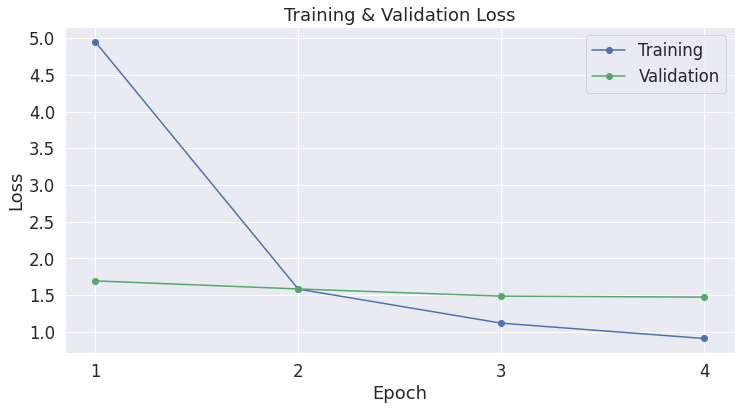

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#testing model score with a sentence
answer="Parachute decreasing the speed while jumping from flight"

In [ ]:
encoded_ans=tokenizer.encode_plus(answer,
                                  max_length=15,
                                  add_special_tokens=True,
                                  pad_to_max_length=True,
                                  return_attention_mask=True,
                                  return_tensors='pt',
                                  truncation=True)

In [ ]:
encoded_ans.keys

<bound method BatchEncoding.keys of {'input_ids': tensor([[  101, 13561, 16922,  1996,  3177,  2096,  8660,  2013,  3462,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}>

In [ ]:
input_ids=encoded_ans['input_ids'].to(device)
attention_mask=encoded_ans['attention_mask'].to(device)

In [ ]:
output=model(input_ids,attention_mask)

In [ ]:
output

(tensor([[5.5779]], device='cuda:0', grad_fn=<AddmmBackward>),)

In [ ]:
#list(output)
score=output[0][0].item()

5.577868938446045

In [ ]:
print(f'The user answer is: {answer}')
print(f'The calculated score is: {score}')

The user answer is: Parachute decreasing the speed while jumping from flight
The calculated score is: 0


In [ ]:
#saving the model

In [ ]:
import os

output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [ ]:
#loading the saved model
from transformers import *
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element